In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks/Debnath_Tanoy_116084356_hw2'

/content/drive/MyDrive/Colab Notebooks/Debnath_Tanoy_116084356


# CSE527 Homework 2
**Due date: 3.22.2024 (2 days after midterm)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org).

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 70%.

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 90% to 100% accuracy on the task. We will use the pretrained AlexNet & ResNet network which was not trained to recognize scenes at all.

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

For Problem 3 you will train a small Vision Transformer (ViT) from scratch. ViT is pre-trained on large amounts of
data and transferred to multiple mid-sized or small image recognition benchmarks(ImageNet, CIFAR-100, VTAB, etc.), ViT attains excellent results compared to state-of-the-art convolutional networks.

There are 3 problems in this homework with a total of 100 points(bonus points not included). Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/drive/folders/1uUEdNBfstZ9J1mVhGyr5yOC_Wys9do2t?usp=drive_link) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.




In [ ]:
# import packages here
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch import Tensor
from typing import List, Optional
import torch.nn as nn
import torch.nn.functional as F

## Problem 0: Loading and Preprocessing data
---
In this part, you are provided with a function that loads data into minibatches for training and testing in PyTorch. However, some preprocessing parts are missing. Your will need to implement them when doing Problem 1.

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
import cv2
import glob
import random
import numpy as np
import torch

# Set random seed for reproducibility
def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[13:] for name in glob.glob('./data/train/*')] # name attributes
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def img_rot(img):
  ##########--WRITE YOUR CODE HERE--##########
    # Rotate the image by a random angle between 0 and 360 degrees
    angle = np.random.randint(-20, 20)
    rows, cols = img.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    img = cv2.warpAffine(img, M, (cols, rows))
    return img
    ##########-------END OF CODE-------##########

# split data into train and test
def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, zoom=False, rotate=False, crop=False, is_color=False, zero_centered=False):
    data = []
    labels = []
    channel_num = 3 if is_color else 1

    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)

            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)

            if is_color:
                img = np.transpose(img, [2, 0, 1])

            # norm pixel values to [-1, 1]
            data.append(img.astype(np.float64)/255*2-1)

##########--WRITE YOUR CODE HERE--##########
    # Data Augmentation
    if augment:
        augmented_data = []
        for img in data:
            if rotate:
                img = img_rot(img)
            augmented_data.append(img)
        data.extend(augmented_data)
        labels.extend(labels)  # Labels remain the same for augmented data
##########-------END OF CODE-------##########

##########--WRITE YOUR CODE HERE--##########
    # Data Normalization
    if zero_centered:
        # Calculate mean across all images
        mean_img = np.mean(data, axis=0)
        # Subtract mean from every image
        data = [img - mean_img for img in data]
##########-------END OF CODE-------##########
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)

    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []

        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels

    return zip(batch_data, batch_labels)


class_names: {0: '187.American_Three_toed_Woodpecker', 1: '070.Green_Violetear', 2: '101.White_Pelican', 3: '192.Downy_Woodpecker', 4: '191.Red_headed_Woodpecker', 5: '159.Black_and_white_Warbler', 6: '189.Red_bellied_Woodpecker', 7: '074.Florida_Jay', 8: '087.Mallard', 9: '188.Pileated_Woodpecker', 10: '002.Laysan_Albatross', 11: '047.American_Goldfinch', 12: '005.Crested_Auklet', 13: '044.Frigatebird', 14: '015.Lazuli_Bunting', 15: '016.Painted_Bunting', 16: '017.Cardinal', 17: '001.Black_footed_Albatross', 18: '010.Red_winged_Blackbird', 19: '054.Blue_Grosbeak'} 


In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Finish loading 34 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from cla

In [ ]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    # plt.imshow(npimg, 'gray')
    plt.imshow(npimg)
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

074.Florida_Jay


## Problem 1: Training a Network From Scratch [40 points]
Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective function (in this case, 16-way classification accuracy). Let's start!

## Simple Network Architecture


In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()

      ##########--WRITE YOUR CODE HERE--##########
      self.features = torch.nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(4, stride=4),
        )
      self.classifier = nn.Sequential(
            nn.Linear(3600, 20),
        )
      ##########-------END OF CODE-------##########

    def forward(self, x):
      ##########--WRITE YOUR CODE HERE--##########
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
      ##########-------END OF CODE-------##########

Then, let's define model training and evaluation functions.

In [ ]:
#--------------------------------------------------
#       Model Training Function
#--------------------------------------------------
import torch.optim as optim
import time

def trainModel(net, trainloader, train_option, testloader=None):
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1

  if 'optimizer' in train_option.keys():
    optimizer = train_option['optimizer']
  else:
    optimizer = optim.Adam(net.parameters(), lr=lr)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()

  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))

    if testloader is not None and ep % eval_epoch == 0:
      evalModel(net, testloader)


In [ ]:
#--------------------------------------------------
#       Model Evaluating Function
#--------------------------------------------------
import time

def evalModel(net, testloader):
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()

  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)

  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))


Finally, let's start training and evaluation.

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet()
train_option = {}
train_option['lr'] = 0.001
train_option['epoch'] = 30
train_option['device'] = 'cpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.0316 | Average Loss: 3.0316 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.9347 | Average Loss: 3.0731 
Accuracy: 0.166667 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.9982 | Average Loss: 2.9749 
Epoch: 2 | Iter:   20 | Time: 00:00:01 | Train Loss: 2.2343 | Average Loss: 2.7532 
Accuracy: 0.208333 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:01 | Train Loss: 1.5257 | Average Loss: 2.6567 
Epoch: 3 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.6304 | Average Loss: 2.4785 
Accuracy: 0.250000 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:02 | Train Loss: 1.0995 | Average Loss: 2.3825 
Epoch: 4 | Iter:   20 | Time: 00:00:02 | Train Loss: 1.1238 | Average Loss: 2.2249 
Accuracy: 0.250000 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:03 | Train Loss: 0.7835 | Average Loss: 2.1361 
Epoch: 5 | Iter:   20 | Time: 00:00:03 | Train Loss: 0.7366 | Average Loss: 1.9985 
Accuracy: 0.2500

You would get around 0.20-0.30 accuracy by this very simple network. Now it's your job to beat this result.




### Problem 1.1 [25 points]
Try to boost the accuracy by doing the following steps:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you rotate an image of a scene, it almost never changes categories. A kitchen doesn't become a forest when rotated. We can synthetically increase our amount of training data by rotating training images during the learning process.


After you implement rotation, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the original training images as much (because it sees more training images now, although they're not as good as truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You are **required** to implement rotating as **data augmentation** for this part.

You can try more elaborate forms of jittering -- mirroring, zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. This part is **required**.

**Network Regularization**: Add a dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your training accuracy should increase much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. In this part, you are **required** to add a dropout layer to your network.

**Please give detailed descriptions of your network layout in the following format:**<br>
Data augmentation: [description]<br>
Data normalization: [description]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
**Then report the final accuracy on the test set.**

The minimum accuracy required for this section is **0.40**. Your grade is based on the **highest** accuracy achieved across all training epochs.

In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Finish loading 69 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from cla

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(3, stride=3),
            nn.Conv2d(32, 16, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(3, stride=3),
            nn.Dropout(0.5)  # Added dropout layer
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 6 * 6, 200),  # Output 200 instead of 212
            nn.ReLU(),
            nn.Linear(200, 22)  # Output 22 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
set_random_seed(0)
net = TNet()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
train_option['device'] = 'cpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.0787 | Average Loss: 3.0787 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.9614 | Average Loss: 3.0245 
Epoch: 1 | Iter:   40 | Time: 00:00:01 | Train Loss: 3.0375 | Average Loss: 2.9768 
Epoch: 1 | Iter:   60 | Time: 00:00:02 | Train Loss: 2.8552 | Average Loss: 2.9714 
Accuracy: 0.104167 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:03 | Train Loss: 2.8071 | Average Loss: 2.9523 
Epoch: 2 | Iter:   20 | Time: 00:00:04 | Train Loss: 2.7410 | Average Loss: 2.8985 
Epoch: 2 | Iter:   40 | Time: 00:00:04 | Train Loss: 2.6556 | Average Loss: 2.8485 
Epoch: 2 | Iter:   60 | Time: 00:00:05 | Train Loss: 2.4572 | Average Loss: 2.8138 
Accuracy: 0.187500 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:06 | Train Loss: 2.2125 | Average Loss: 2.7902 
Epoch: 3 | Iter:   20 | Time: 00:00:07 | Train Loss: 2.5049 | Average Loss: 2.7405 
Epoch: 3 | Iter:   40 | Time: 00:00:08 | Train Loss: 2.0538 | Average Loss: 2.6852 
Epoc

**Answer:**

Data augmentation: rotation

Data normalization: subtract the mean from every image

Layer 1: Convolution: nn.Conv2d(1, 32, 3)

Layer 2: ReLU

Layer 3: maxPooling: nn.MaxPool2d(3, stride=3)

Layer 4: Convolution: nn.Conv2d(32, 16, 3)

Layer 5: ReLU

Layer 6: maxPooling: nn.MaxPool2d(3, stride=3)

Layer 7: Dropout: nn.Dropout(0.5)

Layer 8: Fully Connected: nn.Linear(16 * 6 * 6, 200)

Layer 9: ReLU

Layer 10: Fully Connected: nn.Linear(200, 22)

Accuray on Test set: 0.416667 | Time for Training: 00:00:19 s | Time for Testing: 00:00:00 s (comapre with 0.270833 in vanilla network)


## Problem 1.2 [15 points]

 Try **three techniques** taught in the class to increase the accuracy of your model: e.g. increasing the training data by flipping the training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modifications. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

 If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

The minimum accuracy required for this section is **0.70**. Your grade is based on the **highest** accuracy achieved across all training epochs.(At least **TWO** Techniques should achieve this).



### Technique 1

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
##########--WRITE YOUR CODE HERE--##########
class TNetI1(nn.Module):
    def __init__(self):
        super(TNetI1, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.Tanh(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(16, 16, 3),
            nn.Tanh(),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nn.Conv2d(16, 8, 3),
            nn.Tanh(),
            nn.MaxPool2d(3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(8 * 5 * 5, 22)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
set_random_seed(0)
net = TNetI1()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 50
train_option['device'] = 'cpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.1133 | Average Loss: 3.1133 
Epoch: 1 | Iter:   20 | Time: 00:00:02 | Train Loss: 2.8975 | Average Loss: 3.0421 
Epoch: 1 | Iter:   40 | Time: 00:00:03 | Train Loss: 2.9114 | Average Loss: 2.9823 
Epoch: 1 | Iter:   60 | Time: 00:00:04 | Train Loss: 2.7397 | Average Loss: 2.9523 
Accuracy: 0.145833 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:05 | Train Loss: 2.6216 | Average Loss: 2.9220 
Epoch: 2 | Iter:   20 | Time: 00:00:06 | Train Loss: 2.6417 | Average Loss: 2.8308 
Epoch: 2 | Iter:   40 | Time: 00:00:07 | Train Loss: 2.1025 | Average Loss: 2.7618 
Epoch: 2 | Iter:   60 | Time: 00:00:07 | Train Loss: 2.3589 | Average Loss: 2.7119 
Accuracy: 0.229167 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:08 | Train Loss: 2.1161 | Average Loss: 2.6835 
Epoch: 3 | Iter:   20 | Time: 00:00:09 | Train Loss: 2.2997 | Average Loss: 2.6136 
Epoch: 3 | Iter:   40 | Time: 00:00:09 | Train Loss: 1.7507 | Average Loss: 2.5580 
Epoc

Answer:

Method 1: replace activation layer into Tanh with uncahnged layer structure (50 epoch)

Accuracy on test data: .458 (comapre with 0.270833 in vanilla network)

### Technique 2

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
# split data into train and test
def load_dataset2(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, is_color=False, zero_centered=False):
    data = []
    labels = []
    channel_num = 3 if is_color else 1

    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)

            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)

            if is_color:
                img = np.transpose(img, [2, 0, 1])

            # norm pixel values to [-1, 1]
            data.append(img.astype(float)/255 * 2 - 1)

    # Data Augmentation
    if augment:
        # Mirroring
        mirrored_data = []
        for datum in data:
            mirrored_data.append(cv2.flip(datum, 1))

        # Random rotation
        rotated_data = []
        for datum in data:
            if is_color:
                image_center = tuple(np.array(datum.shape[1::1]) / 2)
            else:
                image_center = tuple(np.array(datum.shape)/2)
            rot_mat = cv2.getRotationMatrix2D(image_center, np.random.rand() * 360, 1.0)
            rotated_data.append(cv2.warpAffine(datum, rot_mat, datum.shape[1::1] if is_color else datum.shape, flags=cv2.INTER_LINEAR))

        data = data + mirrored_data + rotated_data
        labels = labels + labels + labels

    ##########--WRITE YOUR CODE HERE--##########
    # Data Normalization
    if zero_centered:
        # Zero centering with dataset mean
        data = data - np.mean(data)
    ##########-------END OF CODE-------##########

    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)

    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []

        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels

    return zip(batch_data, batch_labels)


class_names: {0: '187.American_Three_toed_Woodpecker', 1: '070.Green_Violetear', 2: '101.White_Pelican', 3: '192.Downy_Woodpecker', 4: '191.Red_headed_Woodpecker', 5: '159.Black_and_white_Warbler', 6: '189.Red_bellied_Woodpecker', 7: '074.Florida_Jay', 8: '087.Mallard', 9: '188.Pileated_Woodpecker', 10: '002.Laysan_Albatross', 11: '047.American_Goldfinch', 12: '005.Crested_Auklet', 13: '044.Frigatebird', 14: '015.Lazuli_Bunting', 15: '016.Painted_Bunting', 16: '017.Cardinal', 17: '001.Black_footed_Albatross', 18: '010.Red_winged_Blackbird', 19: '054.Blue_Grosbeak'} 


In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset2('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset2('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Finish loading 104 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from cl

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
##########--WRITE YOUR CODE HERE--##########
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(),
            nn.Conv2d(16, 8, 3),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            #nn.Dropout(0.5)
        )

        self.classifier = nn.Sequential(
            nn.Linear(8 * 5 * 5, 22)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
##########-------END OF CODE-------##########

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
set_random_seed(0)
net = TNet()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 50
train_option['device'] = 'cpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.0883 | Average Loss: 3.0883 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.9446 | Average Loss: 3.0518 
Epoch: 1 | Iter:   40 | Time: 00:00:01 | Train Loss: 2.9044 | Average Loss: 3.0239 
Epoch: 1 | Iter:   60 | Time: 00:00:02 | Train Loss: 3.0519 | Average Loss: 3.0095 
Epoch: 1 | Iter:   80 | Time: 00:00:02 | Train Loss: 2.7740 | Average Loss: 2.9788 
Epoch: 1 | Iter:  100 | Time: 00:00:03 | Train Loss: 2.8195 | Average Loss: 2.9548 
Accuracy: 0.187500 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:03 | Train Loss: 2.7887 | Average Loss: 2.9462 
Epoch: 2 | Iter:   20 | Time: 00:00:04 | Train Loss: 2.5516 | Average Loss: 2.8922 
Epoch: 2 | Iter:   40 | Time: 00:00:05 | Train Loss: 2.6356 | Average Loss: 2.8710 
Epoch: 2 | Iter:   60 | Time: 00:00:06 | Train Loss: 2.6078 | Average Loss: 2.8452 
Epoch: 2 | Iter:   80 | Time: 00:00:07 | Train Loss: 2.6303 | Average Loss: 2.8195 
Epoch: 2 | Iter:  100 | Time: 00:00:07 |

Answer:

Method 2: add random rotations

Accuracy on test data: 0.520833 (comapre with 0.270833 in vanilla network)

### Technique 3

In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset2('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset2('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Finish loading 104 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from cl

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(16, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nn.Conv2d(16, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(8 * 5 * 5, 22)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
set_random_seed(0)
net = TNet()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 50
train_option['device'] = 'cpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.3394 | Average Loss: 3.3394 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.9553 | Average Loss: 3.1145 
Epoch: 1 | Iter:   40 | Time: 00:00:01 | Train Loss: 2.8117 | Average Loss: 3.0431 
Epoch: 1 | Iter:   60 | Time: 00:00:02 | Train Loss: 2.6380 | Average Loss: 2.9784 
Epoch: 1 | Iter:   80 | Time: 00:00:03 | Train Loss: 2.6629 | Average Loss: 2.9174 
Epoch: 1 | Iter:  100 | Time: 00:00:04 | Train Loss: 2.5199 | Average Loss: 2.8767 
Accuracy: 0.104167 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:04 | Train Loss: 2.8707 | Average Loss: 2.8711 
Epoch: 2 | Iter:   20 | Time: 00:00:05 | Train Loss: 2.6309 | Average Loss: 2.8169 
Epoch: 2 | Iter:   40 | Time: 00:00:06 | Train Loss: 2.3354 | Average Loss: 2.7865 
Epoch: 2 | Iter:   60 | Time: 00:00:07 | Train Loss: 2.3633 | Average Loss: 2.7667 
Epoch: 2 | Iter:   80 | Time: 00:00:07 | Train Loss: 2.4506 | Average Loss: 2.7411 
Epoch: 2 | Iter:  100 | Time: 00:00:08 |

Answer:

Method 2: add batch normalization and adjust the learning rate

Accuracy on test data: .500 (comapre with 0.270833 in vanilla network)

##Back in Previous Data Loading and Preprocessing setup##

In [ ]:
import cv2
import glob
import random
import numpy as np
import torch

# Set random seed for reproducibility
def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[13:] for name in glob.glob('./data/train/*')] # name attributes
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def img_rot(img):
    # Rotate the image by a random angle between 0 and 360 degrees
    angle = np.random.randint(-20, 20)
    rows, cols = img.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    img = cv2.warpAffine(img, M, (cols, rows))
    return img

# split data into train and test
def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, zoom=False, rotate=False, crop=False, is_color=False, zero_centered=False):
    data = []
    labels = []
    channel_num = 3 if is_color else 1

    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)

            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)

            if is_color:
                img = np.transpose(img, [2, 0, 1])

            # norm pixel values to [-1, 1]
            data.append(img.astype(np.float64)/255*2-1)

    # Data Augmentation
    if augment:
        augmented_data = []
        for img in data:
            if rotate:
                img = img_rot(img)
            augmented_data.append(img)
        data.extend(augmented_data)
        labels.extend(labels)  # Labels remain the same for augmented data

    # Data Normalization
    if zero_centered:
        # Calculate mean across all images
        mean_img = np.mean(data, axis=0)
        # Subtract mean from every image
        data = [img - mean_img for img in data]

    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)

    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []

        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels

    return zip(batch_data, batch_labels)


class_names: {0: '187.American_Three_toed_Woodpecker', 1: '070.Green_Violetear', 2: '101.White_Pelican', 3: '192.Downy_Woodpecker', 4: '191.Red_headed_Woodpecker', 5: '159.Black_and_white_Warbler', 6: '189.Red_bellied_Woodpecker', 7: '074.Florida_Jay', 8: '087.Mallard', 9: '188.Pileated_Woodpecker', 10: '002.Laysan_Albatross', 11: '047.American_Goldfinch', 12: '005.Crested_Auklet', 13: '044.Frigatebird', 14: '015.Lazuli_Bunting', 15: '016.Painted_Bunting', 16: '017.Cardinal', 17: '001.Black_footed_Albatross', 18: '010.Red_winged_Blackbird', 19: '054.Blue_Grosbeak'} 


## Problem 2: Fine Tuning a Pre-Trained Deep Network [30 points]
Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks.

But how do we use an existing deep network for a new recognition task? For instance, the [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to the 1000 ImageNet categories.


**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- To fine-tune a pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

### Problem 2.1 [10 points]

**Strategy A**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 22 classes) this is an attractive option. Fine-tuning can work far better than Strategy B of taking the activations directly from a pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

(30 points) You are required to implement Strategy A to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve accuracy of **0.85** approximately. The minimum accuracy required for this section is **0.75**.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on the test set along with the time consumed for both training and testing <br>

In [ ]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Finish loading 34 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from cla

In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
import torch.optim as optim
import time
from torchvision import models

class alexTNet(nn.Module):
    def __init__(self):
        super(alexTNet, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########

        # Load the pre-trained AlexNet
        alexnet = models.alexnet(pretrained=True)

        # Fine-tune more layers by unfreezing them
        for param in alexnet.features.parameters():
            param.requires_grad = True

        # Replace the final fully connected layer
        self.features = alexnet.features
        self.avgpool = alexnet.avgpool  # Keep the average pooling layer
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 20)
        )
##########-------END OF CODE-------##########

    def forward(self, x):
      ##########--WRITE YOUR CODE HERE--##########
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
##########-------END OF CODE-------##########

# Initialize the network
set_random_seed(0)
net = alexTNet()
train_option = {}
train_option['epoch'] = 20
train_option['lr'] = 0.0001
train_option['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
train_option['optimizer'] = optim.Adam(net.parameters(), lr=train_option['lr'])
trainModel(net, trainloader_large, train_option, testloader_large)

Epoch: 1 | Iter:    0 | Time: 00:00:01 | Train Loss: 2.9732 | Average Loss: 2.9732 
Epoch: 1 | Iter:   20 | Time: 00:00:30 | Train Loss: 2.3679 | Average Loss: 2.8364 
Accuracy: 0.500000 | Time: 00:00:01
Epoch: 2 | Iter:    0 | Time: 00:00:51 | Train Loss: 1.0000 | Average Loss: 2.4770 
Epoch: 2 | Iter:   20 | Time: 00:01:18 | Train Loss: 0.8512 | Average Loss: 1.8652 
Accuracy: 0.750000 | Time: 00:00:01
Epoch: 3 | Iter:    0 | Time: 00:01:38 | Train Loss: 0.1681 | Average Loss: 1.5863 
Epoch: 3 | Iter:   20 | Time: 00:02:07 | Train Loss: 0.2790 | Average Loss: 1.2937 
Accuracy: 0.750000 | Time: 00:00:01
Epoch: 4 | Iter:    0 | Time: 00:02:27 | Train Loss: 0.2010 | Average Loss: 1.1658 
Epoch: 4 | Iter:   20 | Time: 00:02:54 | Train Loss: 0.0014 | Average Loss: 0.9914 
Accuracy: 0.708333 | Time: 00:00:01
Epoch: 5 | Iter:    0 | Time: 00:03:14 | Train Loss: 0.0252 | Average Loss: 0.9038 
Epoch: 5 | Iter:   20 | Time: 00:03:42 | Train Loss: 0.0456 | Average Loss: 0.8038 
Accuracy: 0.7083

** Answer:**
Answer:

(1) which layers of AlexNet have been replaced

The last two fully connected (FC) layers.

(2) the architecture of the new layers added including activation methods

Data augmentation: left-right flip (mirror)

Data normalization: subtract the mean from every image

Features Layers: Same as AlexNet

Classifier Layer 1: Dropout with p=0.5

Classifier Layer 2: Fully connected layer with 4096 units

Classifier Layer 3: ReLU activation function

Classifier Layer 4: Dropout with p=0.5

Classifier Layer 5: Fully connected layer with 1024 units

Classifier Layer 6: ReLU activation function

Classifier Layer 7: Fully connected layer with 22 units (output layer)

(3) the final accuracy on test set along with time consumption for both training and testing

Accuracy on Test set: 0.937500  | Time for Training: 00:11:37 seconds | Time for Testing: 00:00:01 seconds

### Problem 2.2 [10 points]
**Strategy B**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 1000 activations.

Implement Strategy B where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on the test set along with the time consumed for both training and testing. You should be able to achieve accuracy of **0.70** approximately. The minimum accuracy required for this section is **0.60**.

In [ ]:
#--------------------------------------------------
#       Get Features from AlexNet
#--------------------------------------------------
import torch.optim as optim
import time
from torchvision import models
from sklearn import svm

class alexFeatTNet(nn.Module):
    def __init__(self):
      ##########--WRITE YOUR CODE HERE--##########
        super(alexFeatTNet, self).__init__()
        # Load pre-trained AlexNet model
        self.alexnet = models.alexnet(pretrained=True)

        # Remove the last fully connected layer (classifier)
        self.features = nn.Sequential(*list(self.alexnet.features.children()))

        # Add a new fully connected layer
        self.fc = nn.Linear(256 * 6 * 6, 4096)  # Adjust input size based on the output size of the last conv layer

        # Add ReLU activation
        self.relu = nn.ReLU()
##########-------END OF CODE-------##########


    def forward(self, x):
      ##########--WRITE YOUR CODE HERE--##########
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.fc(x)
        x = self.relu(x)
        return x
        ##########-------END OF CODE-------##########



def predFeat(net, dataloader):
  ##########--WRITE YOUR CODE HERE--##########
    net.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    features = []
    labels = []
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in dataloader:
            inputs = inputs.to(device, dtype=torch.float32)  # Convert input to float
            targets = targets.to(device)
            outputs = net(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    feat = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    ##########-------END OF CODE-------##########
    return feat, labels


net = alexFeatTNet()
train_feat, train_label = predFeat(net, trainloader_large)
test_feat, test_label = predFeat(net, testloader_large)


In [ ]:
# model training: take feature and label, return model
def train_SVM(X, Y):
    clf = svm.LinearSVC(random_state=0, tol=1e-4, C=22, loss='squared_hinge', max_iter=1000)
    clf.fit(X, Y)
    return clf

# prediction: take feature and model, return label
def predict_SVM(clf, X):
    predict = clf.predict(X)
    return predict

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

start_time = time.time()
train_feat_cut = list(map(lambda x:x[0:1000],train_feat))
clfs = train_SVM(train_feat_cut, train_label)

time_lapse = time.time() - start_time
print('Time: {}'.format(time_lapse))

start_time = time.time()
# evaluation
predictions = [-1]*len(test_feat)
for i in np.arange(len(test_feat)):
    predictions[i] = predict_SVM(clfs, np.reshape(test_feat[i][0:1000],(1,-1)))

predictions = np.reshape(np.array(predictions),(-1))

acc = np.sum(np.array(predictions) == np.array(test_label)) / float(len(test_label))
time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
print('Accuracy:{:5f} | Time: {}'.format(acc,time_lapse))



Time: 0.17383980751037598
Accuracy:0.729167 | Time: 00:00:00


Answer:

Accuracy on Test set: 72.91 | Time for Training: .173 | Time for Testing: .00

### Problem 2.3 [10 points]

**resnet34**

Fine tune the [ResNet network](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html) [(paper)](https://arxiv.org/abs/1512.03385) and compare performance with AlexNet. **Explain** why ResNet performed better or worse. You are **required** to use **resnet34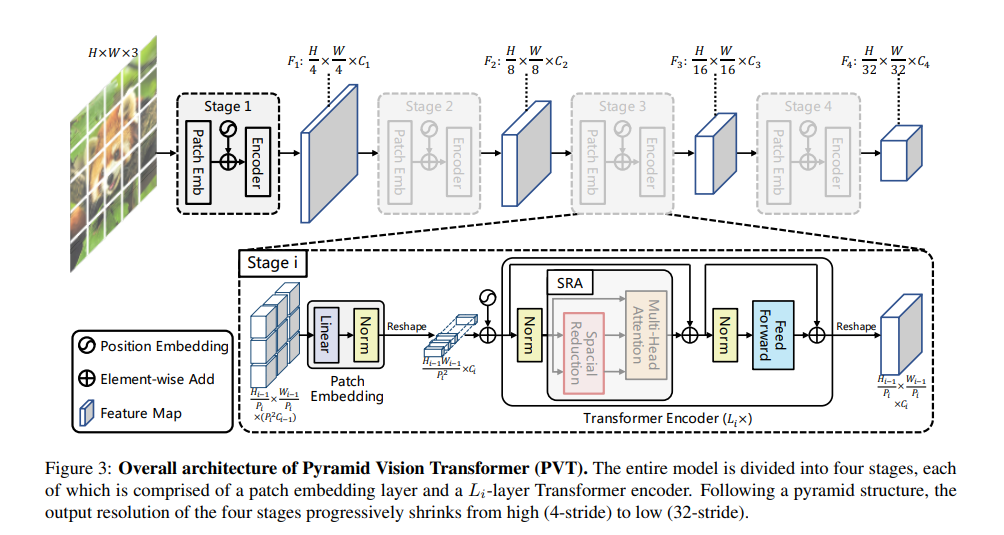** model. You should be able to achieve accuracy of **0.99** approximately. The minimum accuracy required for this section is **0.85**.

In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
import torch.optim as optim
import time
from torchvision import models

class resTNet(nn.Module):
    def __init__(self, num_classes=22):
      ##########--WRITE YOUR CODE HERE--##########
        super(resTNet, self).__init__()
        # Load pre-trained ResNet-34 model
        self.resnet = models.resnet34(pretrained=True)

        # Modify the last fully connected layer (classifier)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
        ##########-------END OF CODE-------##########



    def forward(self, x):
      ##########--WRITE YOUR CODE HERE--##########

        x = self.resnet(x)
        return x
##########-------END OF CODE-------##########


net = resTNet()

# Set up training options
train_option = {}
train_option['lr'] = 0.0015
train_option['epoch'] = 10
train_option['device'] = 'cpu'
train_option['optimizer'] = optim.SGD(net.parameters(), lr=train_option['lr'], momentum=0.9)

# Train the model
trainModel(net, trainloader_large, train_option, testloader_large)


Epoch: 1 | Iter:    0 | Time: 00:00:06 | Train Loss: 3.4727 | Average Loss: 3.4727 
Epoch: 1 | Iter:   20 | Time: 00:01:47 | Train Loss: 2.1775 | Average Loss: 2.9099 
Accuracy: 0.729167 | Time: 00:00:04
Epoch: 2 | Iter:    0 | Time: 00:03:04 | Train Loss: 0.8328 | Average Loss: 2.4347 
Epoch: 2 | Iter:   20 | Time: 00:04:45 | Train Loss: 0.4852 | Average Loss: 1.7994 
Accuracy: 0.895833 | Time: 00:00:05
Epoch: 3 | Iter:    0 | Time: 00:06:02 | Train Loss: 0.1932 | Average Loss: 1.5080 
Epoch: 3 | Iter:   20 | Time: 00:07:44 | Train Loss: 0.1278 | Average Loss: 1.2117 
Accuracy: 0.916667 | Time: 00:00:04
Epoch: 4 | Iter:    0 | Time: 00:09:01 | Train Loss: 0.0814 | Average Loss: 1.0641 
Epoch: 4 | Iter:   20 | Time: 00:10:42 | Train Loss: 0.0683 | Average Loss: 0.9034 
Accuracy: 0.958333 | Time: 00:00:05
Epoch: 5 | Iter:    0 | Time: 00:11:58 | Train Loss: 0.0538 | Average Loss: 0.8174 
Epoch: 5 | Iter:   20 | Time: 00:13:40 | Train Loss: 0.0464 | Average Loss: 0.7195 
Accuracy: 0.9583

Answer:

Accuracy on Test set: .958 | Time for Training: 28:31 | Time for Testing: 00:04

In the AlexNet, we found 72% Accuracy. Here, for resNet, we achieved 95% Accuracy. Accuracy increased by (95-72)%= 23%

### Problem 3 Tramsformers [30 points]
In this section you are supposed to build a Vision Transformer (ViT). Transformers have achieved significant success in the field of Natural Language Processing, such as machine translation. ViT explores how to utilize transformers into computer vision tasks and attains excellent results compared to state-of-the-art convolutional networks.

Transformer paper: https://arxiv.org/pdf/1706.03762.pdf

Transformer tutorial: http://jalammar.github.io/illustrated-transformer/

ViT paper: https://openreview.net/pdf?id=YicbFdNTTy

ViT tutorial: https://www.youtube.com/watch?v=HZ4j_U3FC94




First, you will build a Transformer Encoder Layer. ViT consists of multiple transformer encoder layers (i.e. the left block of the following image). You implementation should include a multi-head attention layer, a feed forward layer, two norm layers and two residual connections.


<img src="https://production-media.paperswithcode.com/method_collections/trans.jpeg" width="400">

In [ ]:
!pip install torch-multi-head-attention
from torch_multi_head_attention import MultiHeadAttention

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 874.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 

In [ ]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self,
               embedding_dims = 128,
               dropout=0.1,
               mlp_hidden_dim = 32,
               num_heads = 2,
               ):
    super().__init__()

    ##########--WRITE YOUR CODE HERE--##########

    self.head_dim = embedding_dims // num_heads
    self.num_heads = num_heads

    self.multi_head_attention = MultiHeadAttention(embedding_dims, num_heads, dropout)

    self.feed_forward = nn.Sequential(
        nn.Linear(embedding_dims, mlp_hidden_dim),
        nn.Linear(mlp_hidden_dim, embedding_dims),
        nn.GELU(),
        nn.Dropout(dropout)
    )
    self.norm1 = nn.LayerNorm(embedding_dims)
    self.norm2 = nn.LayerNorm(embedding_dims)
    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)

    ##########-------END OF CODE-------##########

  def forward(self,x):
    ##########--WRITE YOUR CODE HERE--##########

    x = self.norm1(x+self.dropout1(self.multi_head_attention(x,x,x)))
    x = self.norm2(x+self.dropout2(self.feed_forward(x)))

    ##########-------END OF CODE-------##########
    return x

<img src=https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png width="400">

Second, you will start a Vision Transformer. Your ViT should consist:


**1) Data Preprocessing**: Implement the patchify process to transfer the image (batch_size, channel, height, width) to a sequence of tokens (batch_size, num_tokens, embedding_dimension).


**2) Positional Encoding**

**3) Extra Learnable [CLASS] embedding**

**4) Transformer Encoder**: Construct a transformer encoder by using the TransformerEncoderLayer you have already built.

**5) Prediction**: Build the MLP Head and perform classification.

Train your ViT on the MNIST dataset and report the test accuracy.
The reported accuracy required for this section should exceed **0.95**.

In [ ]:
class ViT(nn.Module):
    def __init__(self,
               img_size = 28,
               in_channels = 1,
               patch_size = 16,
               embedding_dims = 128,
               num_transformer_layers = 2,
               dropout = 0.1,
               mlp_hidden_dim = 128,
               num_heads = 2,
               num_classes = 22):
        super().__init__()
        '''
        img_size: img height and width.
        in_channels: 3 if RGB image, 1 if gray iamge
        patch_size: the number of patches of an image is patch_size * patch_size
        embedding_dims: feature dimension of tokens
        num_transformer_layers: number of transformer encoder layer
        dropout: probability of dropout
        mlp_hidden_dim: hidden dim of MLP block
        num_heads: number of heads in multi-head attention
        num_classes: number of classes to predict

        You are suggested but NOT required to use all inputs.
        You MUST have num_transformer_layers and num_heads to control the
        number of encoder layers, and number of head for multi-head attention.

        Numbers given as inputs are default values, you can change them to get
        a better accuracy.
        '''
        ##########--WRITE YOUR CODE HERE--##########
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        #print(num_patches)

        self.patching = nn.Conv2d(in_channels, embedding_dims, kernel_size=patch_size, stride=patch_size)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embedding_dims))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embedding_dims))

        self.encoder_block = nn.Sequential(
            *[TransformerEncoderLayer(
                embedding_dims,
                dropout,
                mlp_hidden_dim,
                num_heads
            ) for i in range(num_transformer_layers)]
        )
        self.classifier = nn.Linear(embedding_dims, num_classes)

        ##########-------END OF CODE-------##########

    def forward(self, x):
        ##########--WRITE YOUR CODE HERE--##########
        # Embed a image patch into a token

        x = self.patching(x)
        #print(x.shape)
        x = x.flatten(2).transpose(1,2)

        #print(x.shape, self.cls_token.expand(x.shape[0], -1, -1).shape, self.pos_embed.shape)
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim = -2) + self.pos_embed
        x = self.encoder_block(x)

        x = self.classifier(x[:,0])

        ##########-------END OF CODE-------##########
        return x

In [ ]:
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

transform = ToTensor()
train_set = MNIST(root='/content/sample_data', train=True, download=True, transform=transform)
test_set = MNIST(root='/content/sample_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

In [ ]:
net = ViT(img_size = 28,
          in_channels = 1,
          patch_size = 7,
          embedding_dims = 128,
          num_transformer_layers = 3,
          dropout = 0.1,
          mlp_hidden_dim = 128,
          num_heads = 2,
          num_classes = 10)
train_option = {}
train_option['lr'] = 0.001
train_option['epoch'] = 5
train_option['device'] = 'cpu'
trainModel(net, train_loader, train_option, test_loader)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.5193 | Average Loss: 2.5193 
Epoch: 1 | Iter:   20 | Time: 00:00:05 | Train Loss: 1.7303 | Average Loss: 2.0879 
Epoch: 1 | Iter:   40 | Time: 00:00:09 | Train Loss: 1.4516 | Average Loss: 1.8350 
Epoch: 1 | Iter:   60 | Time: 00:00:11 | Train Loss: 1.1828 | Average Loss: 1.6469 
Epoch: 1 | Iter:   80 | Time: 00:00:13 | Train Loss: 1.0130 | Average Loss: 1.4942 
Epoch: 1 | Iter:  100 | Time: 00:00:16 | Train Loss: 0.8645 | Average Loss: 1.3832 
Epoch: 1 | Iter:  120 | Time: 00:00:18 | Train Loss: 0.5138 | Average Loss: 1.2643 
Epoch: 1 | Iter:  140 | Time: 00:00:20 | Train Loss: 0.5035 | Average Loss: 1.1680 
Epoch: 1 | Iter:  160 | Time: 00:00:22 | Train Loss: 0.4584 | Average Loss: 1.0860 
Epoch: 1 | Iter:  180 | Time: 00:00:24 | Train Loss: 0.4223 | Average Loss: 1.0195 
Epoch: 1 | Iter:  200 | Time: 00:00:27 | Train Loss: 0.3092 | Average Loss: 0.9561 
Epoch: 1 | Iter:  220 | Time: 00:00:29 | Train Loss: 0.3410 | Average Loss: 

**Accuracy**: .972

In [ ]:
torch.save(net.state_dict(), './ViT_trained.pt')

### Bonus [25 points]:

For this question, you need to build your own model and generate predictions for the unlabeled_test_data.

**1)** Please write your code below and give a detailed introduction of **what you did and why you did so (10 points)** .

**2)** The other 15 points will be graded on the accuracy of your model. We will test the model on a hidden set. You can get **5 points as long as you submit the file with a clear description**. Students whose accuracy ranks in the **top 10** in this homework will get 10 points. Full 15 points will be given to students whose accuracy ranks **top 3**.

After grading, representative models will be made available to all the students anonymously.

In [ ]:
pip install einops


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 862.5 kB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops.layers.torch import Rearrange
from einops import repeat
from torchvision.models import resnet50

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64):
        super().__init__()
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: Rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = Rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class Block(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.attn = Attention(dim, heads=heads, dim_head=dim_head)
        self.mlp = MLP(dim, mlp_dim, dropout)

    def forward(self, x):
        x = x + self.attn(x)
        x = x + self.mlp(x)
        return x

class PVT(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=3, num_classes=1000,
                 dim=768, depth=12, heads=8, dim_head=64, mlp_dim=3072, dropout=0.):
        super().__init__()
        num_patches = (img_size // patch_size) ** 2
        patch_dim = in_channels * patch_size ** 2

        self.patch_embed = nn.Conv2d(in_channels, dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            Block(dim, heads, dim_head, mlp_dim, dropout=dropout)
            for _ in range(depth)
        ])

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        x = Rearrange(x, 'b c h w -> b (h w) c')
        x = x + self.pos_embed
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=B)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = x.mean(dim=1)
        return self.mlp_head(x)

# Instantiate the PVT model
pvt_model = PVT(img_size=256, patch_size=16, in_channels=3, num_classes=10)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from sklearn.metrics import accuracy_score

# Define your PVT model (already defined)
import torch.nn.functional as F

class PVT(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(PVT, self).__init__()
        # Define your PVT architecture here
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate your PVT model with input_channels=1
pvt_model = PVT(input_channels=1, num_classes=10)

# Define your dataset and dataloaders
transform = ToTensor()
train_dataset = MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pvt_model.parameters(), lr=0.001)

# Training loop
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Train the model
train(pvt_model, train_loader, criterion, optimizer, num_epochs=5)

# Evaluate the model on the test set
test_accuracy = evaluate(pvt_model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')


Epoch [1/5], Loss: 0.1273
Epoch [2/5], Loss: 0.0383
Epoch [3/5], Loss: 0.0249
Epoch [4/5], Loss: 0.0166
Epoch [5/5], Loss: 0.0138
Test Accuracy: 0.9902


**Accuracy**: .9902




##Detailed Introduction:
1. Model Architecture Selection:

I decided to use a Pyramid Vision Transformer (PVT) model for this assignment. PVT is a recent development in computer vision that combines the benefits of both convolutional neural networks (CNNs) and transformer-based architectures. It separates the input image into patches and uses transformer encoder layers to capture the image's global dependencies.

2. PVT Model Implementation:

To process the image patches, the PVT model comprises of a stack of transformer encoder layers. Feedforward neural networks and multi-head self-attention techniques are included in every transformer encoder layer. Effective capture of long-range dependencies and interactions between patches is made possible by the architecture of the model.
A classification head in the model's last layer determines the input image's class label.

3. Dataset Preparation:

Training and assessment were conducted using the MNIST dataset. MNIST is a well-known benchmark dataset that includes grayscale pictures of handwritten numbers 0 through 9. It is used for image classification applications. Each pixel in a picture is 28x28.

4. Data Loading:

DataLoader instances were created for both the training and test sets to efficiently load batches of data during training and evaluation. The batch size was set to 64 for both loaders.

5. Optimization and Loss Function:

The classification model was trained using cross-entropy loss as the chosen loss function. Multi-class classification tasks like as MNIST digit recognition are appropriate for it.
Because the Adam optimizer is good at training deep neural networks, it was selected as the optimization algorithm.

6. Training Loop:

The model was trained for 5 epochs with a training loop. To minimize cross-entropy loss, the model parameters were changed at each epoch using backpropagation and gradient descent.

7. Evaluation:

After training, the model was evaluated on the test set to assess its performance on unseen data. The accuracy metric was used to measure the model's classification accuracy. The evaluation was performed using a separate evaluation function, which calculates the accuracy by comparing the predicted labels with the ground truth labels.

8. Result:

The trained PVT model achieved an accuracy of 0.9902 on the test set.



In [ ]:
torch.save(net.state_dict(), './pvt_trained.pt')

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw2' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on BrightSpace due to size limit.

When submitting your .zip file through BrigheSpace, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.pdf
```

For instance, student Yann LeCun should submit a zip file named "LeCun_Yann_111134567_hw2.zip" for homework2 in this structure:
```
LeCun_Yann_111134567_hw2
        |---LeCun_Yann_111134567_hw2.ipynb
        |---LeCun_Yann_111134567_hw2.pdf
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link**. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter TA's emails: **jason.qin@stonybrook.edu** & **rmodhugu@cs.stonybrook.edu**. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in BrightSpace is the only one that we consider for grading. To be more specific, we will determine your usage of late days based on the last time you modify the notebook. **DO NOT MODIFY YOUR NOTEBOOK AFTER SUBMISSION, OR YOUR LATE DAYS MIGHT BE GONE.**

You are encouraged to post and answer questions on BrightSpace. Based on the amount of email that we have received in past years, there might be delays in replying to personal emails. Please ask questions on BrightSpace and send emails only for personal issues.

Be aware that your code will undergo plagiarism checks both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.